# Necessary Libraries


In [1]:
import pandas as pd
import re
import string
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt  
import io
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
from google.colab import files 
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, GRU, Embedding, Dropout, Activation
from keras.layers import Bidirectional
from keras.models import Model
# from  matplotlib import pyplot as plt
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score
from sklearn.metrics import roc_curve, auc,accuracy_score
# Time and counters
from time import perf_counter

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Reading DataSet

In [3]:
#uploaded = files.upload()
dataPath   = "drive/MyDrive/Mahboob/Dataset/" 
heatmaps   = "drive/MyDrive/Mahboob/Heatmaps/"
Visuals    = "drive/MyDrive/Mahboob/Visuals/"
Comparison = "drive/MyDrive/Mahboob/Comparison/"
Model      = "drive/MyDrive/Mahboob/Models/"

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])


def ROC_AUC(y_test, y_pred, fname):
    # evluate true positive rate and false positive rate using sklearn builtin function
    lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred)
    # find area under curve score
    lr_auc = auc(lr_fpr, lr_tpr)

    # display auc score
    print("AUC:", lr_auc)
    # plot linear line with no learning
    plt.plot([0, 1], [0, 1], 'k--')
    # plot tpr and fpr ratio
    plt.plot(lr_fpr, lr_tpr, marker='.', label='lr (auc = %0.3f)' % lr_auc)
    # assign labels
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Receiver Operating Characterisics')
    plt.legend(loc='lower right')
    plt.savefig(f"{Visuals}{fname}")
    # plt.savefig(f"{fname}.jpeg")
    return lr_auc

def get_Metrics(y_test, y_pred, average="macro"):
    
    lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred)
    # find area under curve score
    lr_auc = auc(lr_fpr, lr_tpr)
    precision = precision_score(y_test, y_pred, average = average)
    recall = recall_score(y_test, y_pred, average = average)
    f1_score_ = f1_score(y_test, y_pred, average = average)
    accuracy = accuracy_score(y_test, y_pred)
    #print(f"precision : {precision} recall : {recall} f1_score : {f1_score_} accuracy : {accuracy}")
    return precision, recall, f1_score_, accuracy, lr_auc


In [4]:
data = pd.read_csv(f"{dataPath}spam(madeof).csv")
data.head()

,v1,v2
0,ham,Subject: enron methanol ; meter # : 988291\nth...
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see..."
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar..."
3,spam,"Subject: photoshop , windows , office . cheap ..."
4,ham,Subject: re : indian springs\r\nthis deal is t...


In [5]:
data["spam"] = data.v1
data["text"] = data.v2

# Splitting data

In [6]:
emails_train, emails_test, target_train, target_test = train_test_split(data.text, data.spam, test_size = 0.2) 

In [7]:
data.info

<bound method DataFrame.info of         v1  ...                                               text
0      ham  ...  Subject: enron methanol ; meter # : 988291\nth...
1      ham  ...  Subject: hpl nom for january 9 , 2001\r\n( see...
2      ham  ...  Subject: neon retreat\r\nho ho ho , we ' re ar...
3     spam  ...  Subject: photoshop , windows , office . cheap ...
4      ham  ...  Subject: re : indian springs\r\nthis deal is t...
...    ...  ...                                                ...
5166   ham  ...  Subject: put the 10 on the ft\r\nthe transport...
5167   ham  ...  Subject: 3 / 4 / 2000 and following noms\r\nhp...
5168   ham  ...  Subject: calpine daily gas nomination\r\n>\r\n...
5169   ham  ...  Subject: industrial worksheets for august 2000...
5170  spam  ...  Subject: important online banking alert\r\ndea...

[5171 rows x 4 columns]>

In [8]:
emails_train.shape

(4136,)

In [9]:
data.describe()


,v1,v2,spam,text
count,5171,5171,5171,5171
unique,2,4993,2,4993
top,ham,Subject: calpine daily gas nomination\r\n>\r\n...,ham,Subject: calpine daily gas nomination\r\n>\r\n...
freq,3672,20,3672,20


In [10]:
data.corr()


""


# Preprocessing

In [11]:
def remove_hyperlink(word):
    return  re.sub(r'http\S+', '', word)

def to_lower(word):
    result = word.lower()
    return result

def remove_number(word):
    result = re.sub(r'\d+', '', word)
    return result

def remove_punctuation(word):
    result = word.translate(str.maketrans(dict.fromkeys(string.punctuation)))
    return result

def remove_whitespace(word):
    result = word.strip()
    return result

def replace_newline(word):
    return word.replace('\n','')



def clean_up_pipeline(sentence):
    cleaning_utils = [remove_hyperlink,
                      replace_newline,
                      to_lower,
                      remove_number,
                      remove_punctuation,
                      remove_whitespace]
    for o in cleaning_utils:
        sentence = o(sentence)
    return sentence

x_train = [clean_up_pipeline(o) for o in emails_train]
x_test = [clean_up_pipeline(o) for o in emails_test]

#x_train[0]

In [12]:
le = LabelEncoder()
train_y = le.fit_transform(target_train.values)
test_y = le.transform(target_test.values)

In [13]:
train_y


array([0, 0, 0, ..., 0, 0, 0])

# Tokenize

In [14]:
## some config values 
embed_size = 100 # how big is each word vector
max_feature = 50000 # how many unique words to use (i.e num rows in embedding vector)
max_len = 2000 # max number of words in a question to use

In [15]:
tokenizer = Tokenizer(num_words=max_feature)

tokenizer.fit_on_texts(x_train)

x_train_features = np.array(tokenizer.texts_to_sequences(x_train))
x_test_features = np.array(tokenizer.texts_to_sequences(x_test))

#x_train_features[0]

# Padding

In [16]:
x_train_features = pad_sequences(x_train_features,maxlen=max_len)
x_test_features = pad_sequences(x_test_features,maxlen=max_len)
x_train_features[0]

array([   0,    0,    0, ..., 1160, 7274,  483], dtype=int32)

# Model

In [17]:
embedding_vecor_length = 32

#**LSTM** 

In [18]:
# LSTM
model = tf.keras.Sequential()
model.add(Embedding(max_feature, embedding_vecor_length, input_length=max_len))
model.add(tf.keras.layers.LSTM(64))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 2000, 32)          1600000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,625,889
Trainable params: 1,625,889
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
# LSTM
start = perf_counter()
history = model.fit(x_train_features, train_y, batch_size=512, epochs=10, validation_split=0.2)
duration_lstm = perf_counter() - start
duration_lstm = round(duration_lstm,2)
lstm_history = history 

Epoch 1/10
7/7 [==============================] - 4s 242ms/step - loss: 0.6831 - accuracy: 0.6753 - val_loss: 0.6635 - val_accuracy: 0.6981
Epoch 2/10
7/7 [==============================] - 1s 178ms/step - loss: 0.6322 - accuracy: 0.7125 - val_loss: 0.5794 - val_accuracy: 0.6981
Epoch 3/10
7/7 [==============================] - 1s 177ms/step - loss: 0.5486 - accuracy: 0.7125 - val_loss: 0.5347 - val_accuracy: 0.6981
Epoch 4/10
7/7 [==============================] - 1s 177ms/step - loss: 0.4689 - accuracy: 0.7125 - val_loss: 0.4484 - val_accuracy: 0.7005
Epoch 5/10
7/7 [==============================] - 1s 178ms/step - loss: 0.3377 - accuracy: 0.7709 - val_loss: 0.3487 - val_accuracy: 0.8140
Epoch 6/10
7/7 [==============================] - 1s 177ms/step - loss: 0.2426 - accuracy: 0.9453 - val_loss: 0.2344 - val_accuracy: 0.9094
Epoch 7/10
7/7 [==============================] - 1s 178ms/step - loss: 0.1702 - accuracy: 0.9791 - val_loss: 0.1840 - val_accuracy: 0.9517
Epoch 8/10
7/7 [====

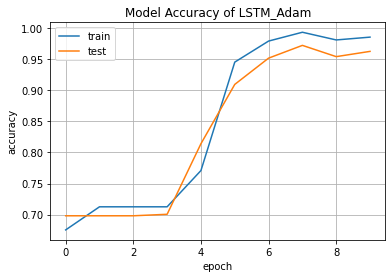

<Figure size 432x288 with 0 Axes>

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy of LSTM_Adam')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()
plt.savefig(f"{Visuals}LSTM-acc-loss.jpeg")

#Confusion Matrix

In [21]:
y_predict  = [1 if o>0.5 else 0 for o in model.predict(x_test_features)]

In [22]:
cf_matrix =confusion_matrix(test_y,y_predict)

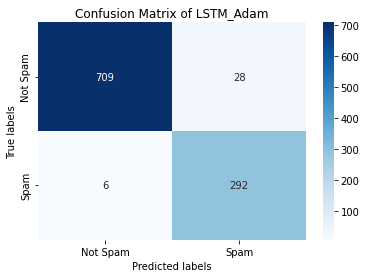

In [23]:
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt=''); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix of LSTM_Adam'); 
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']); ax.yaxis.set_ticklabels(['Not Spam', 'Spam']);
plt.savefig(f"{heatmaps}LSTM-heatmap.jpeg")

In [24]:
tn, fp, fn, tp = confusion_matrix(test_y,y_predict).ravel()

In [25]:
print("Precision: {:.2f}%".format(100 * precision_score(test_y, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(test_y, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(test_y,y_predict)))

Precision: 91.25%
Recall: 97.99%
F1 Score: 94.50%


In [26]:
f1_score(test_y,y_predict)

0.9449838187702266

AUC: 0.9709369564623497


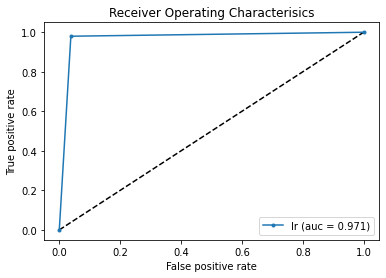

In [27]:
#AUC
auc_lstm = ROC_AUC(test_y, y_predict, "LSTM_AUC.jpeg")

In [28]:
lstm = {
    "train-acc" : history.history["accuracy"][len(history.history["accuracy"])-1],
    "test-acc" : accuracy_score(test_y,y_predict),
    "precision" : precision_score(test_y, y_predict),
    "recall" : recall_score(test_y, y_predict),
    "f1-score" : f1_score(test_y,y_predict),
    "AUC" : auc_lstm,
    "duration" : duration_lstm

}

In [29]:
!ls
model.save("drive/MyDrive/Mahboob/Models/LSTM.h5")

drive  sample_data


In [30]:
lstm

{'AUC': 0.9709369564623497,
 'duration': 15.05,
 'f1-score': 0.9449838187702266,
 'precision': 0.9125,
 'recall': 0.9798657718120806,
 'test-acc': 0.9671497584541063,
 'train-acc': 0.9854897260665894}

#**Bi-LSTM**

In [31]:
# Bilstm
model = tf.keras.Sequential()
model.add(Embedding(max_feature, embedding_vecor_length, input_length=max_len))
model.add(Bidirectional(tf.keras.layers.LSTM(64)))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 32)          1600000   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               49664     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 1,651,745
Trainable params: 1,651,745
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
# BiLSTM
start = perf_counter()
history = model.fit(x_train_features, train_y, batch_size=512, epochs=15, validation_split=0.2)
duration_bi_lstm = perf_counter() - start
duration_bi_lstm = round(duration_bi_lstm,2)
bi_lstm_history = history 


Epoch 1/15
7/7 [==============================] - 6s 446ms/step - loss: 0.6793 - accuracy: 0.6971 - val_loss: 0.6549 - val_accuracy: 0.6981
Epoch 2/15
7/7 [==============================] - 2s 339ms/step - loss: 0.6196 - accuracy: 0.7125 - val_loss: 0.6345 - val_accuracy: 0.6981
Epoch 3/15
7/7 [==============================] - 2s 335ms/step - loss: 0.5815 - accuracy: 0.7125 - val_loss: 0.5748 - val_accuracy: 0.6981
Epoch 4/15
7/7 [==============================] - 2s 336ms/step - loss: 0.5402 - accuracy: 0.7125 - val_loss: 0.5169 - val_accuracy: 0.6981
Epoch 5/15
7/7 [==============================] - 2s 335ms/step - loss: 0.4328 - accuracy: 0.7240 - val_loss: 0.3618 - val_accuracy: 0.7874
Epoch 6/15
7/7 [==============================] - 2s 337ms/step - loss: 0.2411 - accuracy: 0.9495 - val_loss: 0.1911 - val_accuracy: 0.9469
Epoch 7/15
7/7 [==============================] - 2s 336ms/step - loss: 0.2101 - accuracy: 0.9371 - val_loss: 0.2572 - val_accuracy: 0.8998
Epoch 8/15
7/7 [====

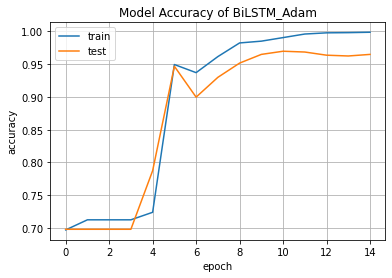

<Figure size 432x288 with 0 Axes>

In [33]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy of BiLSTM_Adam')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()
plt.savefig(f"{Visuals}Bi-LSTM-acc-loss.jpeg")

#Confusion Matrix BiLSTM


In [34]:
y_predict  = [1 if o>0.5 else 0 for o in model.predict(x_test_features)]

In [35]:
cf_matrix =confusion_matrix(test_y,y_predict)

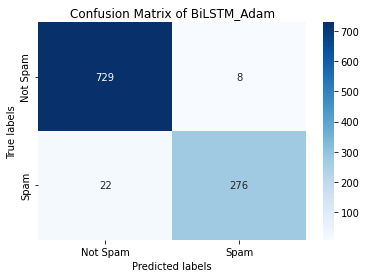

In [36]:
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='') #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of BiLSTM_Adam')
ax.xaxis.set_ticklabels(['Not Spam', 'Spam'])
ax.yaxis.set_ticklabels(['Not Spam', 'Spam'])
plt.savefig(f"{heatmaps}Bi-LSTM-heatmap.jpeg")

In [37]:
tn, fp, fn, tp = confusion_matrix(test_y,y_predict).ravel()

In [38]:
print("Precision: {:.2f}%".format(100 * precision_score(test_y, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(test_y, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(test_y,y_predict)))

Precision: 97.18%
Recall: 92.62%
F1 Score: 94.85%


In [39]:
f1_score(test_y,y_predict)

0.9484536082474226

AUC: 0.9576598399096646


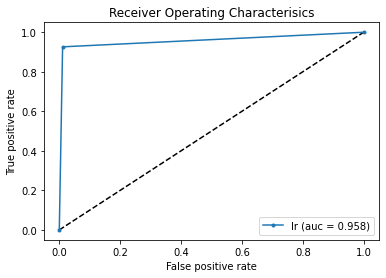

In [40]:
#AUC
auc_bi_lstm = ROC_AUC(test_y, y_predict, "Bi-LSTM_AUC.jpeg")

In [41]:
Bi_lstm = {
    "train-acc" : history.history["accuracy"][len(history.history["accuracy"])-1],
    "test-acc" : accuracy_score(test_y,y_predict),
    "precision" : precision_score(test_y, y_predict),
    "recall" : recall_score(test_y, y_predict),
    "f1-score" : f1_score(test_y,y_predict),
    "AUC" : auc_bi_lstm,
    "duration" : duration_bi_lstm

}

In [42]:
!ls
model.save("drive/MyDrive/Mahboob/Models/Bi_LSTM.h5")

drive  sample_data


In [43]:
Bi_lstm

{'AUC': 0.9576598399096646,
 'duration': 38.17,
 'f1-score': 0.9484536082474226,
 'precision': 0.971830985915493,
 'recall': 0.9261744966442953,
 'test-acc': 0.9710144927536232,
 'train-acc': 0.9987908005714417}

#**GRU**

In [44]:
#GRU
model = tf.keras.Sequential()
model.add(Embedding(max_feature, embedding_vecor_length, input_length=max_len))
# model.add(GRU(units=64, dropout=0.1,recurrent_dropout=0.1))
model.add(tf.keras.layers.GRU(64))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 2000, 32)          1600000   
_________________________________________________________________
gru (GRU)                    (None, 64)                18816     
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 1,619,873
Trainable params: 1,619,873
Non-trainable params: 0
_________________________________________________________________
None


In [45]:
# GRU
start = perf_counter()
history = model.fit(x_train_features, train_y, batch_size=512, epochs=15, validation_split=0.2)
duration_gru = perf_counter() - start
duration_gru = round(duration_gru,2)
gru_history = history 

Epoch 1/15
7/7 [==============================] - 3s 232ms/step - loss: 0.6794 - accuracy: 0.6808 - val_loss: 0.6574 - val_accuracy: 0.6981
Epoch 2/15
7/7 [==============================] - 1s 182ms/step - loss: 0.6318 - accuracy: 0.7125 - val_loss: 0.6038 - val_accuracy: 0.6981
Epoch 3/15
7/7 [==============================] - 1s 181ms/step - loss: 0.5594 - accuracy: 0.7125 - val_loss: 0.5612 - val_accuracy: 0.6981
Epoch 4/15
7/7 [==============================] - 1s 181ms/step - loss: 0.5070 - accuracy: 0.7125 - val_loss: 0.4990 - val_accuracy: 0.6981
Epoch 5/15
7/7 [==============================] - 1s 181ms/step - loss: 0.4138 - accuracy: 0.7237 - val_loss: 0.4089 - val_accuracy: 0.7560
Epoch 6/15
7/7 [==============================] - 1s 182ms/step - loss: 0.2950 - accuracy: 0.8697 - val_loss: 0.3275 - val_accuracy: 0.8273
Epoch 7/15
7/7 [==============================] - 1s 182ms/step - loss: 0.2028 - accuracy: 0.9601 - val_loss: 0.2316 - val_accuracy: 0.9251
Epoch 8/15
7/7 [====

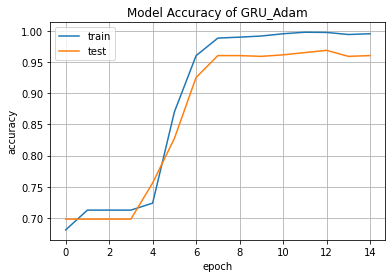

<Figure size 432x288 with 0 Axes>

In [46]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy of GRU_Adam')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()
plt.savefig(f"{Visuals}gru-acc-loss.jpeg")

#Confusion Matrix GRU


In [47]:
y_predict  = [1 if o>0.5 else 0 for o in model.predict(x_test_features)]

In [48]:
cf_matrix =confusion_matrix(test_y,y_predict)

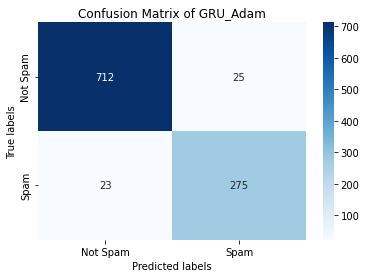

In [49]:
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, ax = ax,cmap='Blues',fmt='') #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix of GRU_Adam') 
ax.xaxis.set_ticklabels(['Not Spam', 'Spam']) 
ax.yaxis.set_ticklabels(['Not Spam', 'Spam'])
plt.savefig(f"{heatmaps}gru-heatmap.jpeg")

In [50]:
tn, fp, fn, tp = confusion_matrix(test_y,y_predict).ravel()

In [51]:
print("Precision: {:.2f}%".format(100 * precision_score(test_y, y_predict)))
print("Recall: {:.2f}%".format(100 * recall_score(test_y, y_predict)))
print("F1 Score: {:.2f}%".format(100 * f1_score(test_y,y_predict)))

Precision: 91.67%
Recall: 92.28%
F1 Score: 91.97%


In [52]:
f1_score(test_y,y_predict)

0.9197324414715717

AUC: 0.9444487446841449


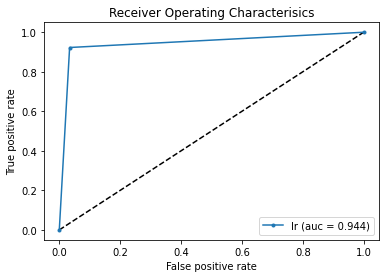

In [53]:
#AUC
auc_gru = ROC_AUC(test_y, y_predict, "gru_AUC.jpeg")

In [54]:
gru = {
    "train-acc" : history.history["accuracy"][len(history.history["accuracy"])-1],
    "test-acc" : accuracy_score(test_y,y_predict),
    "precision" : precision_score(test_y, y_predict),
    "recall" : recall_score(test_y, y_predict),
    "f1-score" : f1_score(test_y,y_predict),
    "AUC" : auc_gru,
    "duration" : duration_gru

}

In [55]:
!ls
model.save("drive/MyDrive/Mahboob/Models/GRU.h5")

drive  sample_data


In [56]:
gru

{'AUC': 0.9444487446841449,
 'duration': 20.68,
 'f1-score': 0.9197324414715717,
 'precision': 0.9166666666666666,
 'recall': 0.9228187919463087,
 'test-acc': 0.9536231884057971,
 'train-acc': 0.9951632618904114}

In [57]:
models_metrics = []
Adam = {
    "lstm-adam" : {
        "train-acc" : 0,
        "test-acc" : 0,
        "precision" : 0,
        "recall" : 0,
        "f1-score" : 0,
        "AUC" : 0,
        "duration" : 0
    },
    "Bi_lstm-adam" : {
        "train-acc" : 0,
        "test-acc" : 0,
        "precision" : 0,
        "recall" : 0,
        "f1-score" : 0,
        "AUC" : 0,
        "duration" : 0
    },
    "gru-adam" : {
        "train-acc" : 0,
        "test-acc" : 0,
        "precision" : 0,
        "recall" : 0,
        "f1-score" : 0,
        "AUC" : 0,
        "duration" : 0
    }
}
for (l,b,g) in zip(lstm,Bi_lstm,gru):
  Adam["lstm-adam"][l] = lstm[l]
  Adam["Bi_lstm-adam"][b] = Bi_lstm[b]
  Adam["gru-adam"][g] = gru[g]   

Adam 



{'Bi_lstm-adam': {'AUC': 0.9576598399096646,
  'duration': 38.17,
  'f1-score': 0.9484536082474226,
  'precision': 0.971830985915493,
  'recall': 0.9261744966442953,
  'test-acc': 0.9710144927536232,
  'train-acc': 0.9987908005714417},
 'gru-adam': {'AUC': 0.9444487446841449,
  'duration': 20.68,
  'f1-score': 0.9197324414715717,
  'precision': 0.9166666666666666,
  'recall': 0.9228187919463087,
  'test-acc': 0.9536231884057971,
  'train-acc': 0.9951632618904114},
 'lstm-adam': {'AUC': 0.9709369564623497,
  'duration': 15.05,
  'f1-score': 0.9449838187702266,
  'precision': 0.9125,
  'recall': 0.9798657718120806,
  'test-acc': 0.9671497584541063,
  'train-acc': 0.9854897260665894}}

In [58]:
models_metrics= []
for name, model in Adam.items():
  # print(name,model)
  #print(model["y_pred"].shape)
  precision, recall, f1_score_,  = model["precision"], model["recall"], model["f1-score"]
  accuracy, lr_auc = model["test-acc"], model["AUC"]
  Train_acc, duration = model["train-acc"], model["duration"]
  #print(f"precision : {precision} recall : {recall} f1_score : {f1_score_} accuracy : {accuracy}")
  models_metrics.append([name, precision, recall, f1_score_, Train_acc, accuracy, lr_auc, duration])

df_metrics = pd.DataFrame(models_metrics)
df_metrics.columns = ['Model', 'Precision', 'Recall', 'f1 score', "Train Accuracy", 'Test Accuracy', 'ROC-AUC', 'Train Time (s)']
df_metrics.sort_values(by = 'Test Accuracy', ascending = False, inplace=True)
df_metrics.reset_index(drop = True, inplace=True)
df_metrics.to_csv(f"{Comparison}Adam_comparison.csv") 

In [59]:
df_metrics

,Model,Precision,Recall,f1 score,Train Accuracy,Test Accuracy,ROC-AUC,Train Time (s)
0,Bi_lstm-adam,0.971831,0.926174,0.948454,0.998791,0.971014,0.957660,38.17
1,lstm-adam,0.912500,0.979866,0.944984,0.985490,0.967150,0.970937,15.05
2,gru-adam,0.916667,0.922819,0.919732,0.995163,0.953623,0.944449,20.68
